In [1]:
from collections import OrderedDict
import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [2]:
import pandas as pd
df = pd.read_csv("../data/delaney-mordred.csv")

In [3]:
max_atoms = 12
feat = dc.feat.MolGanFeaturizer(
    max_atom_count=max_atoms,
    atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]
)
smiles = df['smiles'].values

filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < max_atoms]

In [4]:
features = feat.featurize(filtered_smiles)
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ]
features = [features[i] for i in indices]

/usr/local/lib/python3.10/dist-packages/deepchem/feat/base_classes.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)


In [5]:
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=max_atoms)
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

In [6]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

In [7]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(1000)

Ending global_step 99: generator average loss 4.99869, discriminator average loss 34.5481
TIMING: model fitting took 14.217 s
Generating 1000 samples


In [8]:
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


[06:18:41] Explicit valence for atom # 0 C, 10, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 6, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 0 C, 23, is greater than permitted
[06:18:41] Explicit valence for atom # 1 O, 22, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 1 B, 22, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 0 O, 22, is greater than permitted
[06:18:41] Explicit valence for atom # 5 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[06:18:41] Explicit valence for atom # 0 O, 22, is greater than permitted
[06:18:41] Explicit valence for atom # 0 O, 2

In [9]:
nmols = list(filter(lambda x: x is not None, nmols))

In [10]:
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

35 valid molecules


In [11]:
smiles = [Chem.MolToSmiles(m) for m in nmols]
smiles_unique = list(OrderedDict.fromkeys(smiles))
mols = [Chem.MolFromSmiles(x) for x in smiles_unique]
print ("{} unique valid molecules".format(len(mols)))

29 unique valid molecules


In [12]:
smiles_unique

['CCC1C(C)C1(O)NO',
 'CCC1(C)C(C)C12CC2C',
 'CC1(CO)OC1O',
 'CCCC',
 'OOO',
 'CCC1(C)CC1C1CC1C',
 'CCC1(C)C(C)C12CC2',
 'OCO',
 'COC(O)C(C)C',
 'CCC(O)OC',
 'CC1CC1(C)C',
 'CCCCC',
 'COO',
 'CCO',
 'CCCC(C)C(C)CC',
 'C',
 'CCC1C(C)C1(C)CC',
 'CO',
 'CCC(C)C(O)O',
 'BO',
 'CC1CC12C1CCCC12C',
 'CCCC(C)CC',
 'CC1C2C3C4CC25C1C3(C)C45',
 'CCCC1C(C)C1(C)CC',
 'CCCCC(C)CC',
 'CCC(C)C(C)CC',
 'CCC(C)CC',
 'CCOC(C)C(C)CC',
 'CCC(C)C1CC1(C)CC']

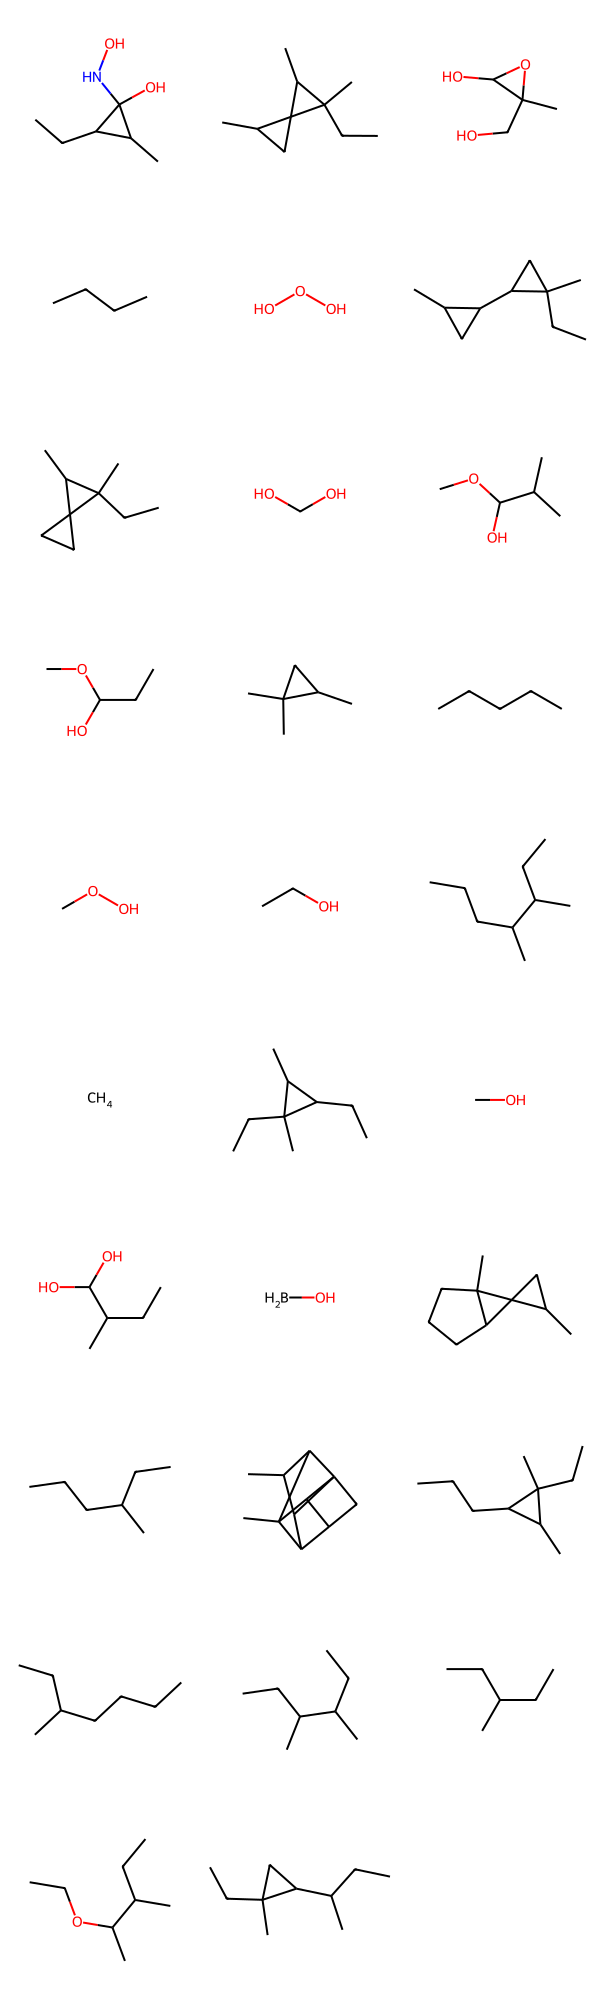

In [13]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols)